# Convert CSV to Xarray and example plots

In [1]:
%matplotlib inline
import xarray as xr
import pandas as pd
import datetime
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [10]:
savename = "predictions/timeseries.nc"
CSVlist = os.listdir('predictions/prediction_CSV')
CSVlist.remove('.DS_Store')

for n, CSVfile in enumerate(CSVlist):
    print('Adding',n+1,'/',len(CSVlist),':',CSVfile)
    times = []
    prediction = []
    predconf = []
    fogconf = []
    iceconf = []
    noconf = []

    data = pd.read_csv(os.path.join('predictions/prediction_CSV',CSVfile),header=None)
    for i in range(len(data)):
        times.append(pd.to_datetime(str(data.iloc[i,0])[:-2]))
        prediction.append(int(data.iloc[i,1]))
        predconf.append(data.iloc[i,2])
        fogconf.append(data.iloc[i,3])
        iceconf.append(data.iloc[i,4])
        noconf.append(data.iloc[i,5])
    
    new_ds = xr.Dataset(
         {
             "prediction": (["time"], prediction),
             "prediction_confidence": (["time"], predconf),
             "fog_confidence": (["time"], fogconf),
             "ice_confidence": (["time"], iceconf),
             "no_confidence": (["time"], noconf)
         },
         coords={
             "time": times,
         },
     )
    if n == 0:
        ds = new_ds
    else:
        ds = xr.concat([ds, new_ds], dim='time')

ds.to_netcdf(savename)
print('Saved as',savename)

Adding 1 / 272 : 20150712.csv
Adding 2 / 272 : 20150706.csv
Adding 3 / 272 : 20170830.csv
Adding 4 / 272 : 20120829.csv
Adding 5 / 272 : 20120815.csv
Adding 6 / 272 : 20120626.csv
Adding 7 / 272 : 20130804.csv
Adding 8 / 272 : 20130805.csv
Adding 9 / 272 : 20100722.csv
Adding 10 / 272 : 20110914.csv
Adding 11 / 272 : 20120627.csv
Adding 12 / 272 : 20190906.csv
Adding 13 / 272 : 20160808.csv
Adding 14 / 272 : 20150711.csv
Adding 15 / 272 : 20200613.csv
Adding 16 / 272 : 20190723.csv
Adding 17 / 272 : 20110916.csv
Adding 18 / 272 : 20130621.csv
Adding 19 / 272 : 20130806.csv
Adding 20 / 272 : 20110917.csv
Adding 21 / 272 : 20120624.csv
Adding 22 / 272 : 20120630.csv
Adding 23 / 272 : 20100523.csv
Adding 24 / 272 : 20190911.csv
Adding 25 / 272 : 20190905.csv
Adding 26 / 272 : 20170615.csv
Adding 27 / 272 : 20140701.csv
Adding 28 / 272 : 20200606.csv
Adding 29 / 272 : 20180928.csv
Adding 30 / 272 : 20200821.csv
Adding 31 / 272 : 20200819.csv
Adding 32 / 272 : 20150728.csv
Adding 33 / 272 :

Adding 261 / 272 : 20160807.csv
Adding 262 / 272 : 20200807.csv
Adding 263 / 272 : 20150722.csv
Adding 264 / 272 : 20200620.csv
Adding 265 / 272 : 20160622.csv
Adding 266 / 272 : 20120819.csv
Adding 267 / 272 : 20100713.csv
Adding 268 / 272 : 20130607.csv
Adding 269 / 272 : 20130809.csv
Adding 270 / 272 : 20170626.csv
Adding 271 / 272 : 20160623.csv
Adding 272 / 272 : 20140530.csv
Saved as predictions/timeseries.nc


## Example plots

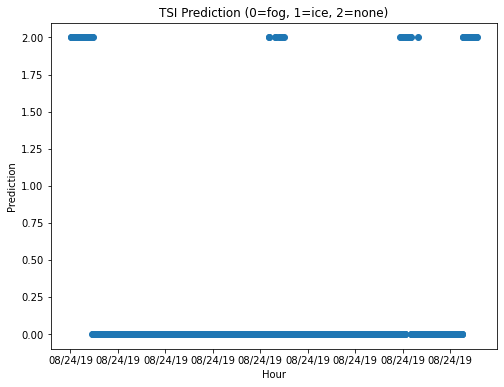

In [35]:
# plot a specific day of predictions

time = '20190824'

ds_sel = ds.sel(time=time)

fig, ax = plt.subplots(figsize=(8,6))
ds_sel.plot.scatter(x='time',y='prediction')
plt.title('TSI Prediction (0=fog, 1=ice, 2=none)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%D'))
plt.xlabel('Hour')
plt.ylabel('Prediction')
plt.show()

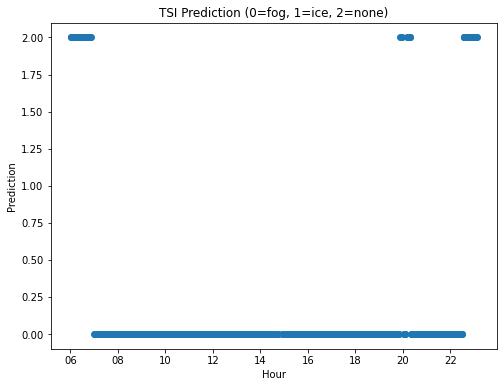

In [36]:
# plot a specific day of predictions above a threshold 

ds_sel = ds.where(ds.prediction_confidence > 0.5).sel(time=time)

fig, ax = plt.subplots(figsize=(8,6))
ds_sel.plot.scatter(x='time',y='prediction')
plt.title('TSI Prediction (0=fog, 1=ice, 2=none)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
plt.xlabel('Hour')
plt.ylabel('Prediction')
plt.show()

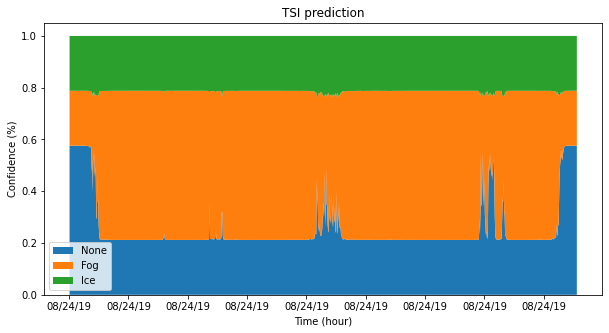

In [37]:
# Lookup the prediction distribution over selected time

ds_stack = ds.sel(time=time)

fig, ax = plt.subplots(figsize=(10,5))
ax.stackplot(ds_stack.time, [ds_stack.no_confidence,ds_stack.fog_confidence,ds_stack.ice_confidence],
             labels=['None','Fog','Ice'])
ax.legend(loc='lower left')
ax.set_title('TSI prediction')
ax.set_xlabel('Time (hour)')
ax.set_ylabel('Confidence (%)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%D'))

plt.show()

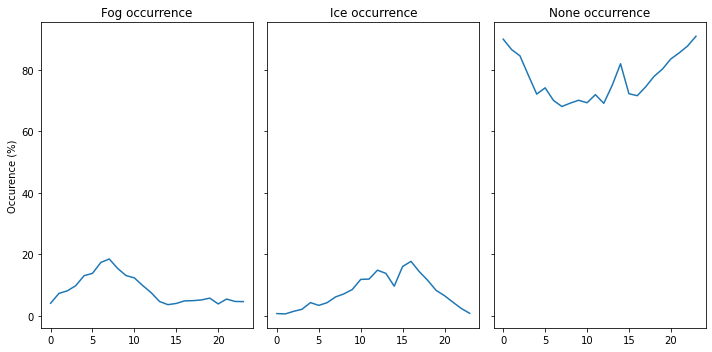

In [38]:
# When does fog/ice/none occur?

conf = 0.5

fogoccur = ds.where(ds.prediction==0).where(ds.prediction_confidence>conf).prediction.groupby('time.hour').count()
iceoccur = ds.where(ds.prediction==1).where(ds.prediction_confidence>conf).prediction.groupby('time.hour').count()
nonoccur = ds.where(ds.prediction==2).where(ds.prediction_confidence>conf).prediction.groupby('time.hour').count()
totoccur = ds.prediction.groupby('time.hour').count()

fig, ax = plt.subplots(1,3, sharex=True, sharey=True,figsize=(10,5))
ax[0].plot(fogoccur.hour, fogoccur/totoccur*100)
ax[0].set_title('Fog occurrence')
ax[0].set_ylabel('Occurence (%)')

ax[1].plot(iceoccur.hour, iceoccur/totoccur*100)
ax[1].set_title('Ice occurrence')

ax[2].plot(nonoccur.hour, nonoccur/totoccur*100)
ax[2].set_title('None occurrence')

plt.tight_layout()
plt.show()

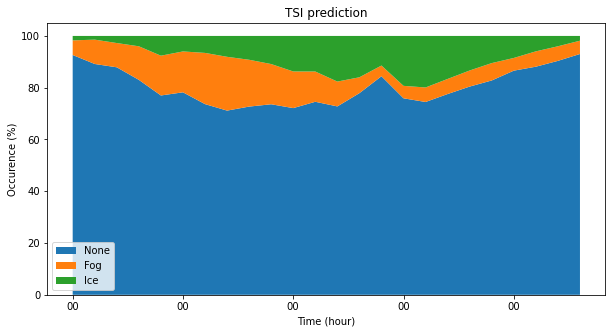

In [33]:
# fog/ice/none average distribution over all data (daily)

totoccur = ds.prediction.groupby('time.hour').count()
fogoccur = ds.where(ds.prediction==0).prediction.groupby('time.hour').count()/totoccur*100
iceoccur = ds.where(ds.prediction==1).prediction.groupby('time.hour').count()/totoccur*100
nonoccur = ds.where(ds.prediction==2).prediction.groupby('time.hour').count()/totoccur*100

fig, ax = plt.subplots(figsize=(10,5))
ax.stackplot(totoccur.hour, [nonoccur, fogoccur, iceoccur],
             labels=['None','Fog','Ice'])
ax.legend(loc='lower left')
ax.set_title('TSI prediction')
ax.set_xlabel('Time (hour)')
ax.set_ylabel('Occurence (%)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

plt.show()

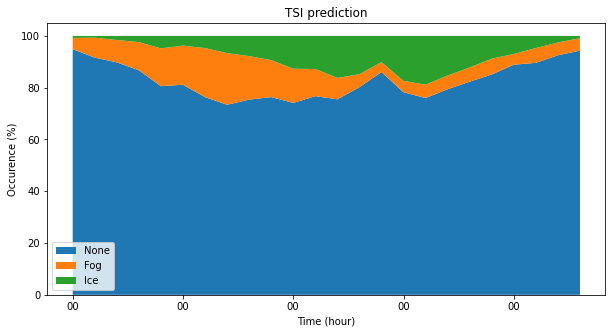

In [34]:
# fog/ice/none average distribution over all data (daily) above confidence threshold

conf = 0.5

totoccur = ds.prediction.where(ds.prediction_confidence>conf).groupby('time.hour').count()
fogoccur = ds.where(ds.prediction==0).where(ds.prediction_confidence>conf).prediction.groupby('time.hour').count()/totoccur*100
iceoccur = ds.where(ds.prediction==1).where(ds.prediction_confidence>conf).prediction.groupby('time.hour').count()/totoccur*100
nonoccur = ds.where(ds.prediction==2).where(ds.prediction_confidence>conf).prediction.groupby('time.hour').count()/totoccur*100

fig, ax = plt.subplots(figsize=(10,5))
ax.stackplot(totoccur.hour, [nonoccur, fogoccur, iceoccur],
             labels=['None','Fog','Ice'])
ax.legend(loc='lower left')
ax.set_title('TSI prediction')
ax.set_xlabel('Time (hour)')
ax.set_ylabel('Occurence (%)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

plt.show()